<h1>Machine Learning Project</h1>

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [92]:
rng = np.random.RandomState(2)

## Dataset

In [93]:
import os
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
    base_dir = "."
dataset_dir = os.path.join(base_dir, "datasets")

In [94]:
df = pd.read_csv(os.path.join(dataset_dir, "concrete.csv"))

## Take a cheeky look

In [95]:
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [96]:
df.shape

(1030, 9)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   fly_ash           1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarse_aggregate  1030 non-null   float64
 6   fine_aggregate    1030 non-null   float64
 7   age               1030 non-null   int64  
 8   strength          1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [98]:
df.describe(include="all")

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## Split into training set and test set

In [99]:
train, test = train_test_split(df, test_size=0.2, random_state=rng)
features = ["cement","slag", "fly_ash","water", "superplasticizer", "coarse_aggregate", "fine_aggregate", "age"]

X_train = train[features]
y_train = train["strength"]
X_test = test[features]
y_test = test["strength"]

##  Exploratory Data Analysis

In [100]:
train_copy = train.copy()

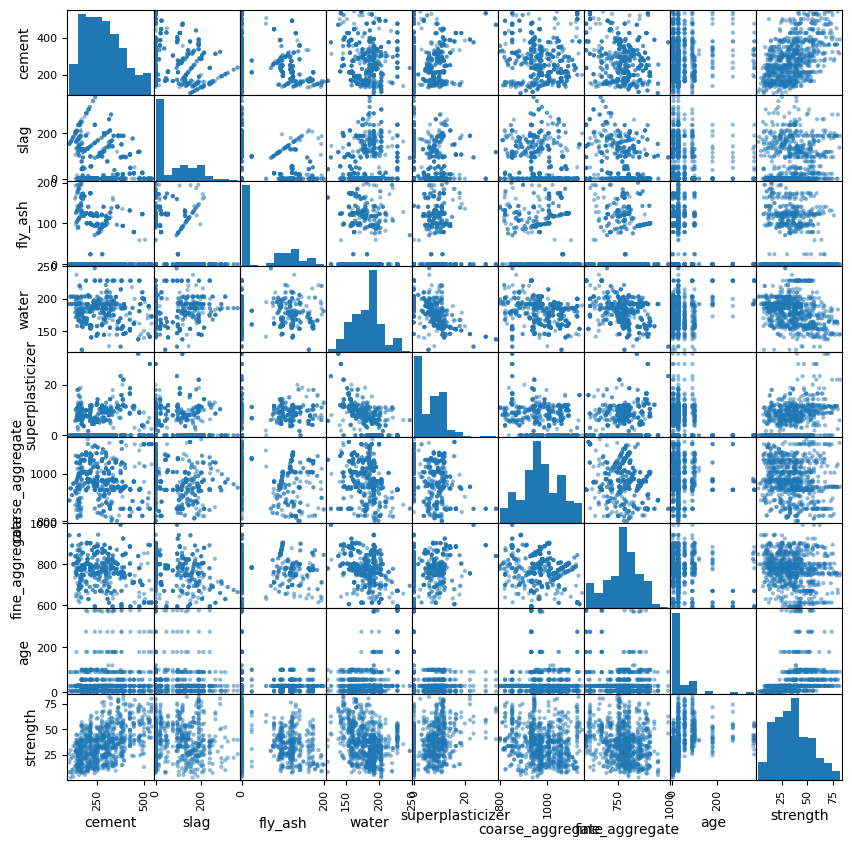

In [101]:
scatter_matrix(train_copy, figsize=(10, 10))
plt.show()

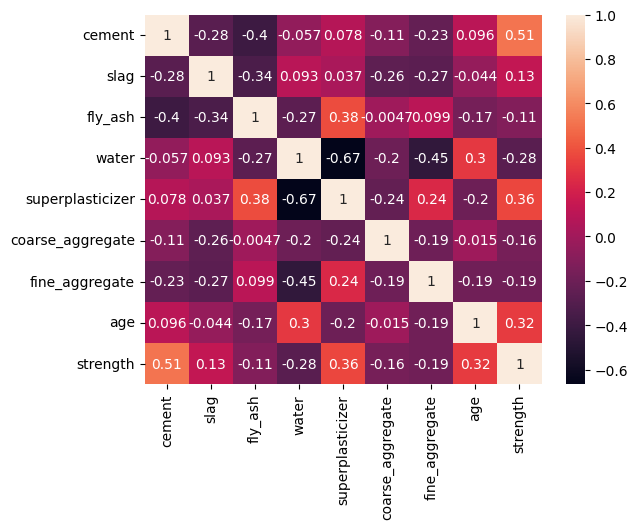

In [102]:
sns.heatmap(train_copy.corr(numeric_only=True), annot=True)
plt.show()

## Feature Engineering

In [103]:
# The ratio of cement to water. (water will never be zero, hence I won't get a div-by-zeror error.)
train_copy["cement_to_water"] = train_copy["cement"] / train_copy["water"]
train_copy["superplasticizer_and_water"] = train_copy["superplasticizer"] * train_copy["water"]
train_copy["total_aggregate"] = train_copy["coarse_aggregate"] + train_copy["fine_aggregate"]
train_copy["cement_to_aggregate"] = train_copy["cement"] / train_copy["total_aggregate"]

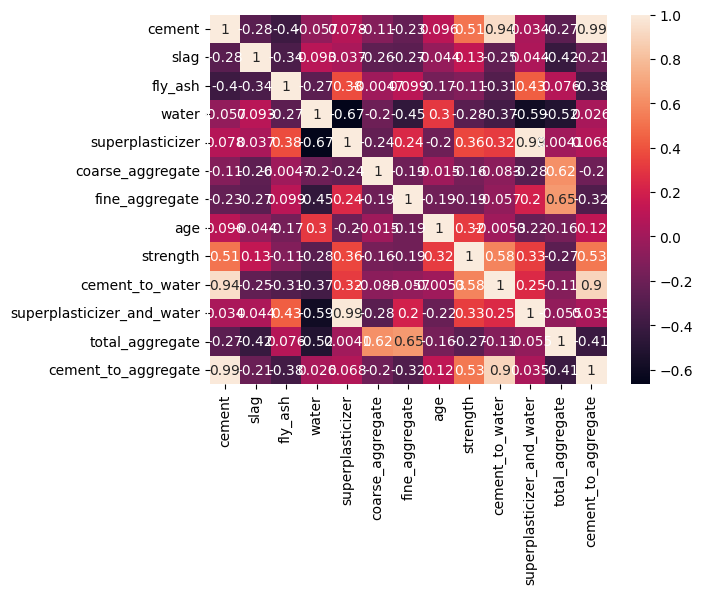

In [104]:
sns.heatmap(train_copy.corr(numeric_only=True), annot=True)
plt.show()

## Preprocess the Data

In [105]:
class InsertCementToWaterRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["cement_to_water"] = X["cement"] / X["water"]
        return X

In [106]:
class InsertSuperplasticizerandWaterRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["superplasticizer_and_water"] = X["superplasticizer"] * X["water"]
        return X

In [107]:
class InsertTotalAggregateRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.insert:
            X["total_aggregate"] = X["coarse_aggregate"] + X["fine_aggregate"]
        return X

In [108]:
preprocessor = Pipeline([
    ("cement_to_water", InsertCementToWaterRatio()),
    ("superplasticizer_and_water", InsertSuperplasticizerandWaterRatio()),
    ("total_aggregate", InsertTotalAggregateRatio()),
    ("scaler", FunctionTransformer())  # placeholder for scaling
])

## Model selection

In [109]:
dummy = DummyRegressor()

dummy.fit(X_train, y_train)

np.mean(cross_val_score(dummy, X_train, y_train, scoring="neg_mean_absolute_error", cv=10))

np.float64(-13.71776847401589)

In [110]:
def grid_search(preprocessor, predictor, param_grid, cv, metric, X_train, y_train):
    model = Pipeline([
                ("preprocessor", preprocessor),
                ("predictor", predictor)
    ])

    gs = GridSearchCV(model, param_grid, scoring=metric, cv=cv, n_jobs=-1)

    gs.fit(X_train, y_train)

    return gs

<h3>k-Nearest Neighbour</h3>

In [111]:
knn_gs = grid_search(
    preprocessor = preprocessor, 
    predictor = KNeighborsRegressor(),
    param_grid = {
        "preprocessor__cement_to_water__insert": [True, False],
        "preprocessor__superplasticizer_and_water__insert": [True, False],
        "preprocessor__total_aggregate__insert": [True, False],
        "preprocessor__scaler" : [None, MinMaxScaler(), RobustScaler(), StandardScaler()],
        "predictor__n_neighbors": range(1, 11) ,
        "predictor__weights" : ["uniform", "distance"]
    },
    cv = 10,
    metric = "neg_mean_absolute_error",
    X_train = X_train,
    y_train = y_train
)

knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 4,
  'predictor__weights': 'distance',
  'preprocessor__cement_to_water__insert': False,
  'preprocessor__scaler': RobustScaler(),
  'preprocessor__superplasticizer_and_water__insert': False,
  'preprocessor__total_aggregate__insert': False},
 np.float64(-5.293142870987982))

<h3>Decision Tree</h3>

In [112]:
decision_tree_gs = grid_search(
    preprocessor = preprocessor, 
    predictor = DecisionTreeRegressor(random_state=rng),
     param_grid = {
        "preprocessor__cement_to_water__insert": [True, False],
        "preprocessor__superplasticizer_and_water__insert": [True, False],
        "preprocessor__total_aggregate__insert": [True, False],
        "preprocessor__scaler" : [None, MinMaxScaler(), RobustScaler(), StandardScaler()],
        "predictor__max_depth": range(1, 11)                 
    },
    cv = 10,
    metric = "neg_mean_absolute_error",
    X_train = X_train,
    y_train = y_train
)

decision_tree_gs.best_params_, decision_tree_gs.best_score_

({'predictor__max_depth': 10,
  'preprocessor__cement_to_water__insert': True,
  'preprocessor__scaler': None,
  'preprocessor__superplasticizer_and_water__insert': True,
  'preprocessor__total_aggregate__insert': True},
 np.float64(-4.341094248501787))

In [89]:
decision_tree = decision_tree_gs.best_estimator_.named_steps["predictor"]
feature_importances = decision_tree.feature_importances_
sorted(list(zip(features + ["cement_to_water"], feature_importances)), key = lambda x: (x[1],x[0]), reverse=True)

[('cement_to_water', np.float64(0.3967869005525919)),
 ('age', np.float64(0.38071694634220743)),
 ('slag', np.float64(0.07074531826280521)),
 ('fine_aggregate', np.float64(0.032630427560572044)),
 ('fly_ash', np.float64(0.024805407975876083)),
 ('coarse_aggregate', np.float64(0.01987664912001824)),
 ('water', np.float64(0.016026250497020077)),
 ('superplasticizer', np.float64(0.015413068931091546)),
 ('cement', np.float64(0.008626512003496824))]

## Error Estimation - evaluate on the the test set

In [113]:
mean_absolute_error(knn_gs.best_estimator_.predict(X_test), y_test)

4.734705313236442

In [114]:
mean_absolute_error(decision_tree_gs.best_estimator_.predict(X_test), y_test)

4.553654125109564